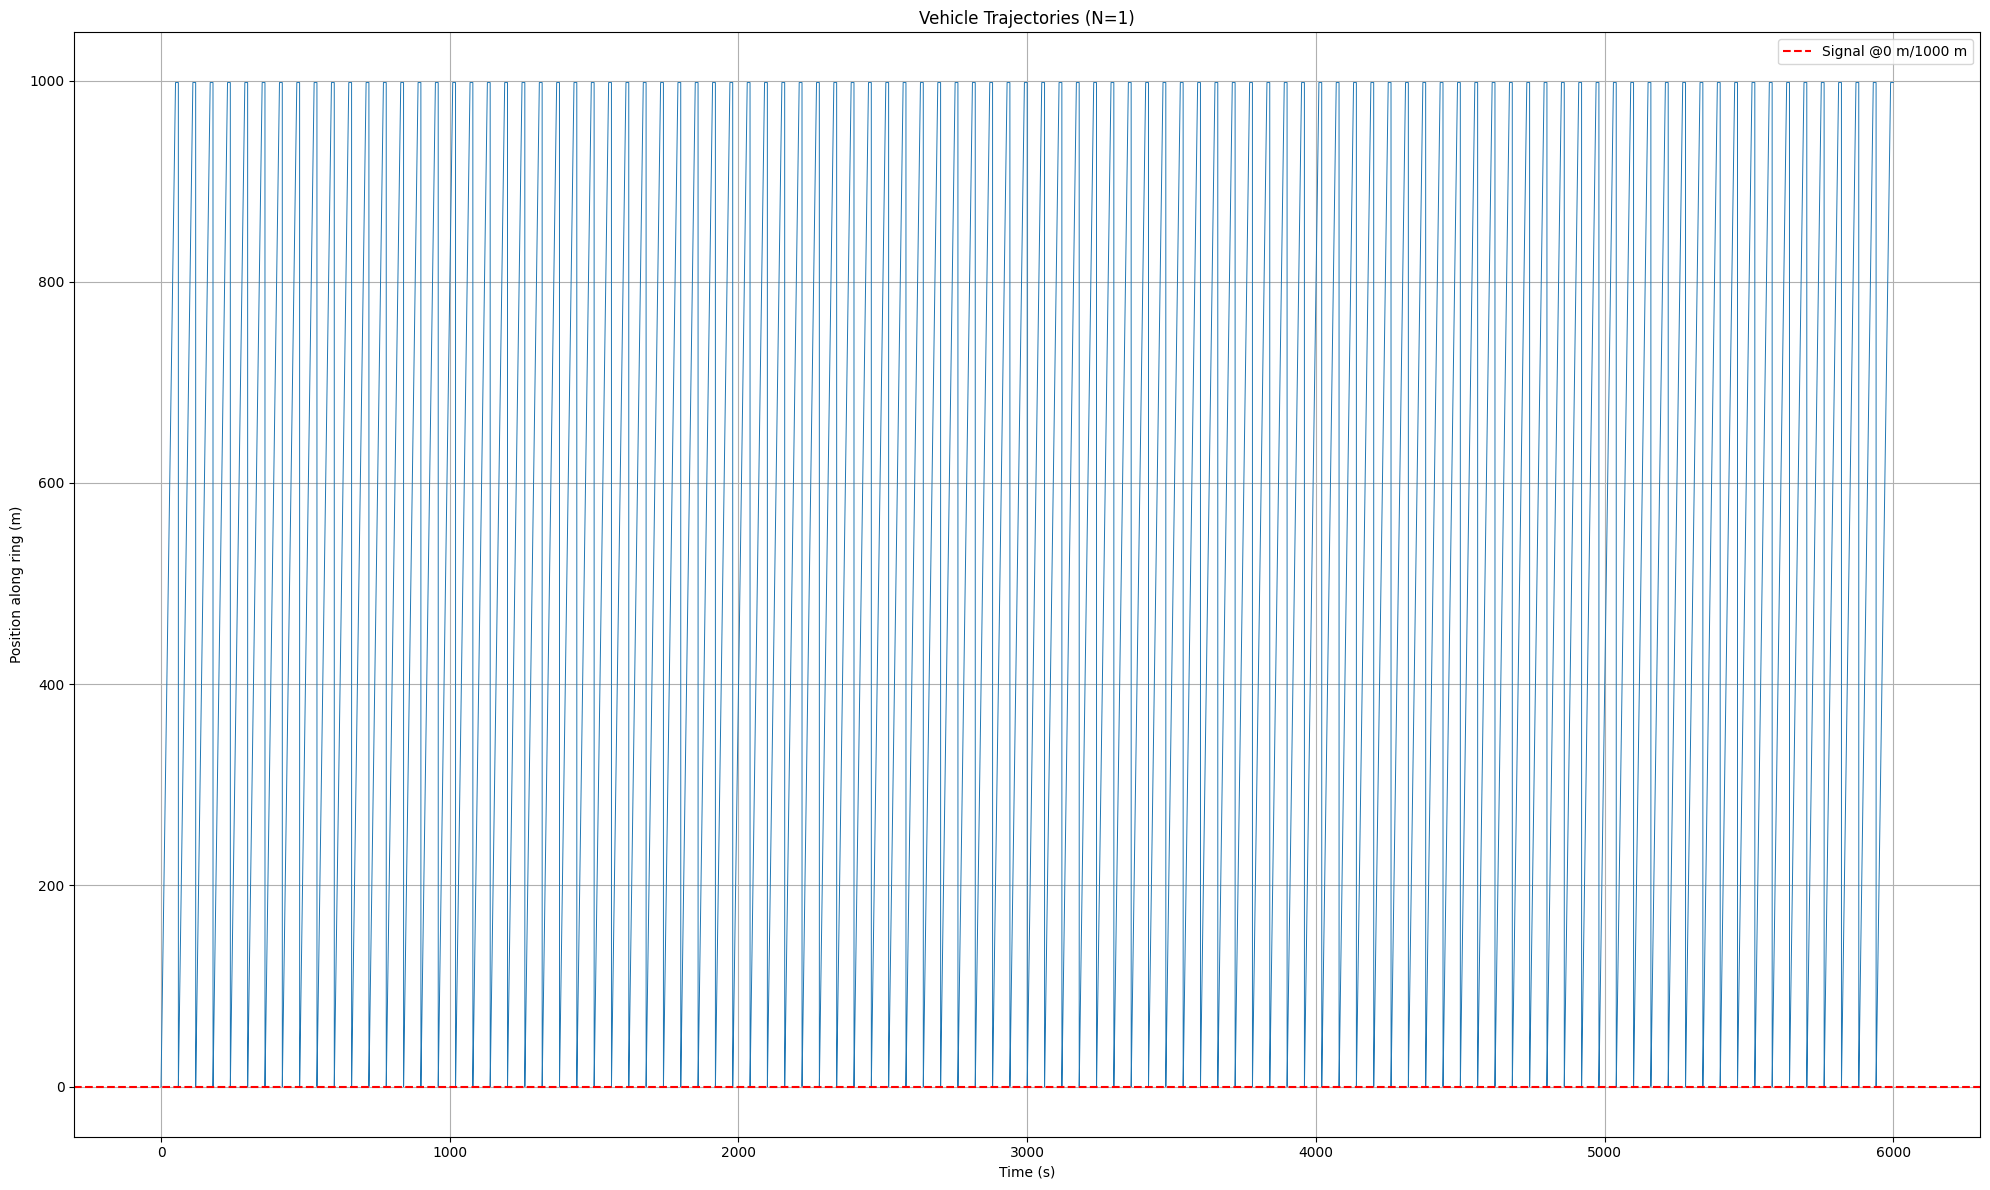

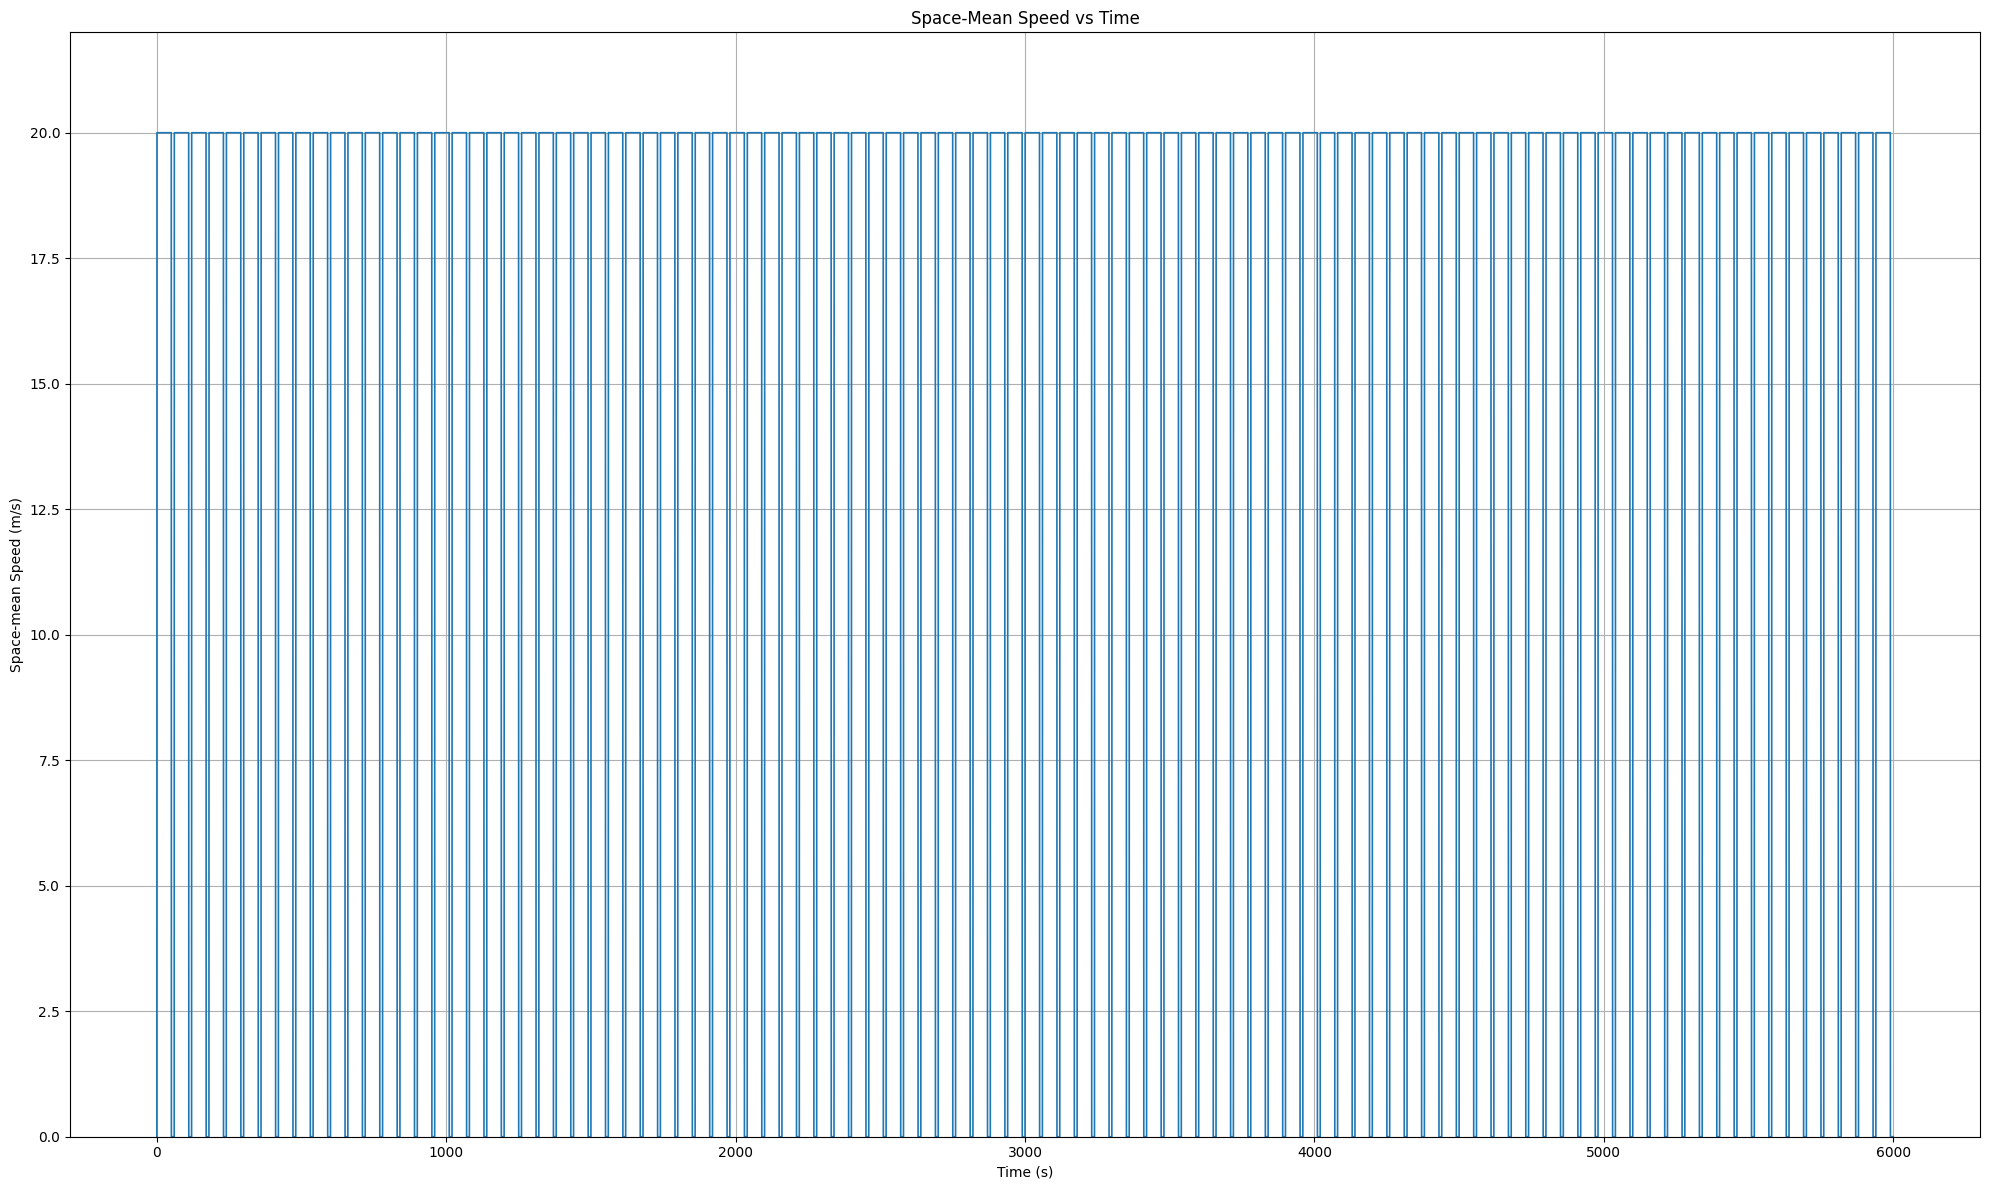

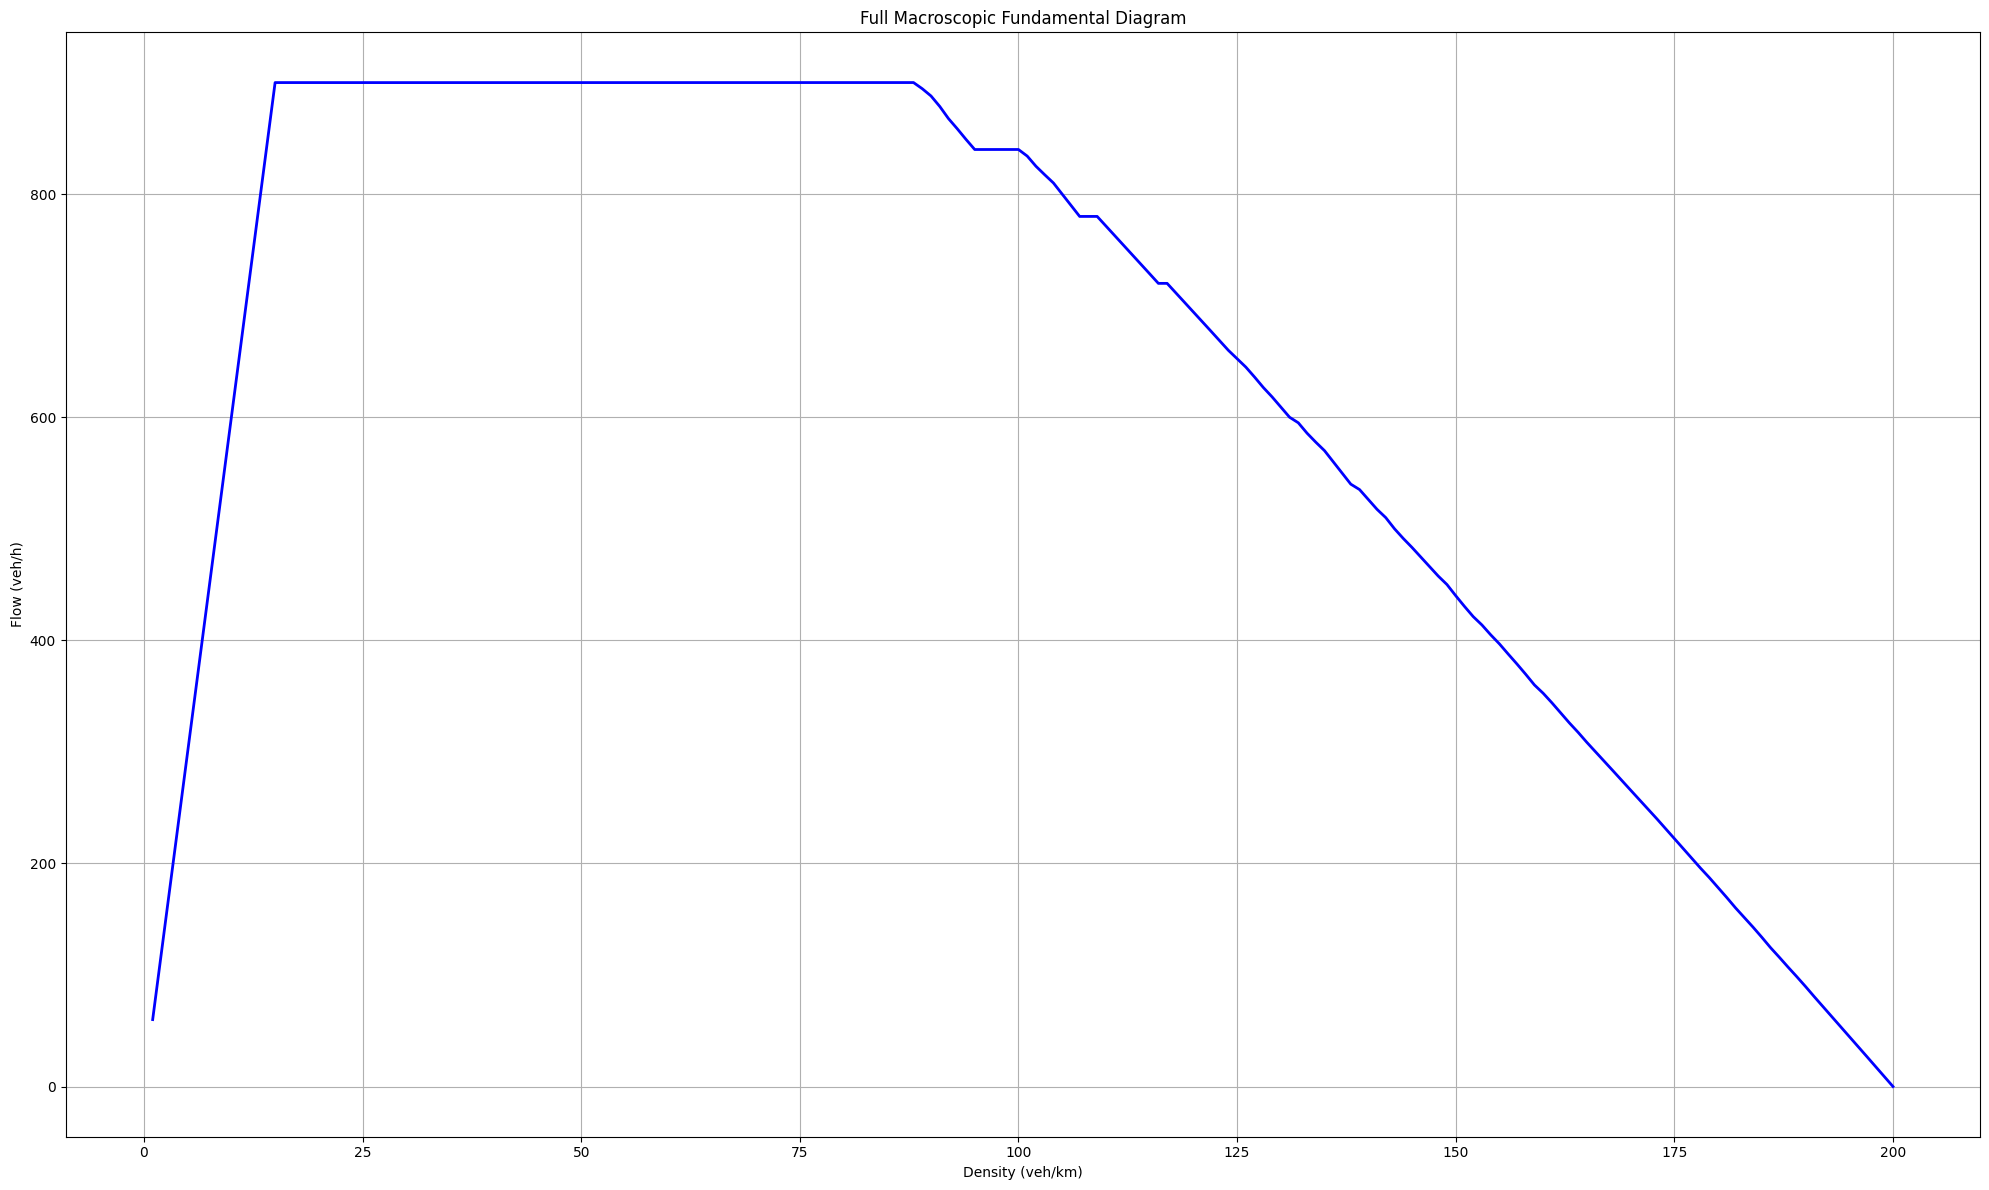

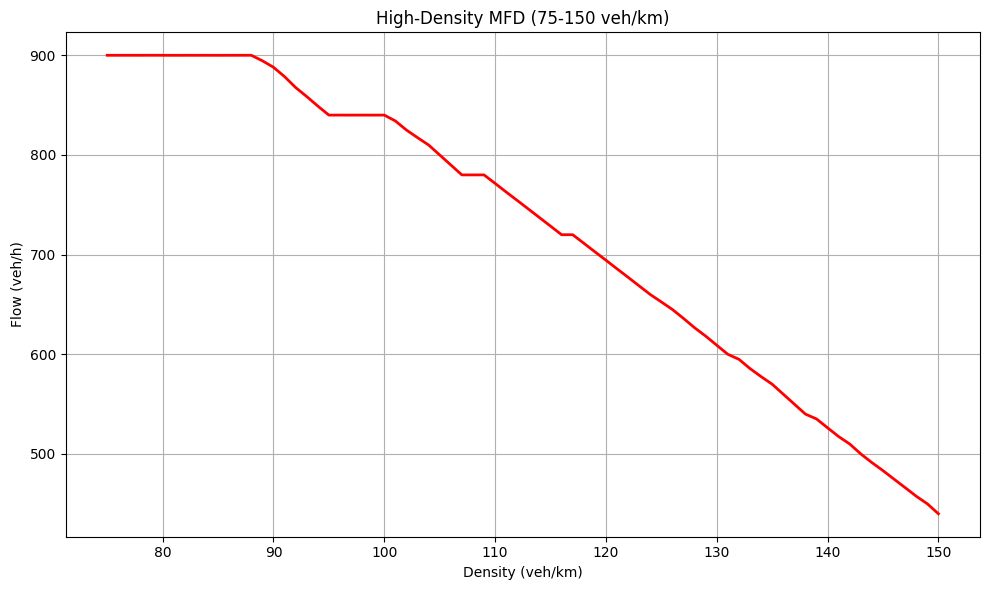

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# === Global Parameters ===
road_length = 1000.0   # meters (circumference)
tau = 2.0              # time gap (s)
L_vehicle = 5.0        # vehicle length (m)
delta_t = 0.1          # simulation time step (s)
v_f = 20.0             # free-flow speed (m/s)
simulation_time = 6000.0  # total simulation time (s)
cycle_time = 60.0      # traffic signal cycle (s)
green_ratio = 0.5      # fraction of cycle that is green
signal_pos = 0.0       # traffic light position (m)

def simulate_signal(N, sim_time):
    time_steps = int(sim_time / delta_t)
    pos_abs = np.linspace(0, road_length, N, endpoint=False)
    velocities = np.zeros(N)
    
    traj = np.zeros((time_steps, N))
    speeds = np.zeros((time_steps, N))

    for t in range(time_steps):
        current_time = t * delta_t
        is_green = (current_time % cycle_time) < (cycle_time * green_ratio)
        
        traj[t] = pos_abs
        speeds[t] = velocities
        
        # Update velocities
        for i in range(N):
            leader = (i + 1) % N
            if pos_abs[leader] > pos_abs[i]:
                gap = pos_abs[leader] - pos_abs[i] - L_vehicle
            else:
                gap = (pos_abs[leader] + road_length) - pos_abs[i] - L_vehicle
            gap = max(gap, 0.0)
            v_cand = min(gap / tau, v_f)
            
            if not is_green:
                next_pos = pos_abs[i] + v_cand * delta_t
                if next_pos >= road_length:
                    velocities[i] = 0.0  # Stop at signal
                else:
                    velocities[i] = v_cand
            else:
                velocities[i] = v_cand
        
        # Update positions
        pos_abs += velocities * delta_t
        
        # Handle position clamping/wrapping
        if not is_green:
            # Clamp positions to road_length during red
            overshoot = pos_abs >= road_length
            pos_abs[overshoot] = road_length
            velocities[overshoot] = 0.0
        else:
            # Wrap around during green
            pos_abs[pos_abs >= road_length] -= road_length

    sms = np.mean(speeds, axis=1)
    return traj, sms

def plot_trajectories(traj, N):
    t = np.arange(traj.shape[0]) * delta_t
    plt.figure(figsize=(20, 12))
    for i in range(N):
        plt.plot(t, traj[:, i], linewidth=0.7)
    plt.axhline(signal_pos, color='r', linestyle='--', label='Signal @0 m/1000 m')
    plt.xlabel('Time (s)')
    plt.ylabel('Position along ring (m)')
    plt.title(f'Vehicle Trajectories (N={N})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_sms(sms):
    t = np.arange(len(sms)) * delta_t
    plt.figure(figsize=(20, 12))
    plt.plot(t, sms, linewidth=1.2)
    plt.xlabel('Time (s)')
    plt.ylabel('Space‐mean Speed (m/s)')
    plt.title('Space‐Mean Speed vs Time')
    plt.ylim(0, v_f * 1.1)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_mfd():
    Ns = np.arange(1, 201)
    q_vals = []
    
    for N in Ns:
        _, sms = simulate_signal(N, simulation_time)
        start_idx = int(0.7 * len(sms))  # Corrected line
        stable_sms = sms[start_idx:] 
        v_avg = stable_sms.mean()
        q = N * v_avg * 3600 / road_length  # Convert to veh/h
        q_vals.append(q)
    
    # Convert to NumPy arrays
    Ns = np.array(Ns)
    q_vals = np.array(q_vals)
    
    # Full MFD
    plt.figure(figsize=(20, 12))
    plt.plot(Ns, q_vals, 'b-', linewidth=2)
    plt.xlabel('Density (veh/km)')
    plt.ylabel('Flow (veh/h)')
    plt.title('Full Macroscopic Fundamental Diagram')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # High-density zoom (75-150 veh/km)
    mask = (Ns >= 75) & (Ns <= 150)
    plt.figure(figsize=(10, 6))
    plt.plot(Ns[mask], q_vals[mask], 'r-', linewidth=2)
    plt.xlabel('Density (veh/km)')
    plt.ylabel('Flow (veh/h)')
    plt.title('High-Density MFD (75-150 veh/km)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    N = int(input("Enter number of vehicles (1–200): "))
    traj, sms = simulate_signal(N, simulation_time)
    plot_trajectories(traj, N)
    plot_sms(sms)
    plot_mfd()